In [1]:
!pip install tables
!pip install torchvision
!pip install shap
!pip install xgboost

  Using cached tables-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached blosc2-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.9 MB)
  Using cached numexpr-2.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [8]:
!pip install positional_encoder

ERROR: Could not find a version that satisfies the requirement positional_encoder (from versions: none)
ERROR: No matching distribution found for positional_encoder


In [125]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Plotting magic
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Load relevant packages
import numpy as np
np.set_printoptions(precision=12)
import pandas as pd
pd.set_option('display.precision', 12)
from sklearn import *
import sys
import subprocess
from datetime import datetime, timedelta
import netCDF4
import time
from functools import partial
import os
import xgboost

# Ensure that working directory is forecast_rodeo
if os.path.basename(os.getcwd()) == "experiments":
    # Navigate to forecast_rodeo
    os.chdir(os.path.join("..",".."))
if os.path.basename(os.getcwd()) != "forecast_rodeo":
    raise Exception("You must be in the forecast_rodeo folder")

# Adds 'experiments' folder to path to load experiments_util
sys.path.insert(0, 'src1/experiments')
# Load general utility functions
from experiments_util2 import *

# Experiment name
experiment = "transformer"

#####

import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap

# Choose target
#
gt_id = "contest_tmp2m" # "contest_precip" or "contest_tmp2m"
target_horizon = "56w" # "34w" or "56w"

# Create list of official contest submission dates in YYYYMMDD format
#
submission_dates = [datetime(y,4,18)+timedelta(14*i) for y in range(2011,2018) for i in range(26)]
submission_dates = ['{}{:02d}{:02d}'.format(date.year, date.month, date.day) for date in submission_dates]
submission_dates = [datetime.strptime(str(d), "%Y%m%d") for d in submission_dates]
submission_dates = pd.Series(submission_dates)

# Create list of target dates corresponding to submission dates in YYYYMMDD format
#
target_dates = pd.Series([get_target_date('{}{:02d}{:02d}'.format(date.year, date.month, date.day), target_horizon) for date in submission_dates])

# Find all unique target day-month combinations
target_day_months = pd.DataFrame({'month' : target_dates.dt.month, 
                                  'day': target_dates.dt.day}).drop_duplicates()

#####

from experiments_util2 import *
# Load functionality for fitting and predicting
from fit_and_predict import *
# Load functionality for evaluation
from skill import *
# Load functionality for stepwise regression
from stepwise_util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
hindcast_features = False if len(sys.argv) < 6 else (sys.argv[5] == "True")
print(hindcast_features)

# Identify measurement variable name
measurement_variable = get_measurement_variable(gt_id) # 'tmp2m' or 'precip'

# column names for gt_col, clim_col and anom_col 
gt_col = measurement_variable
clim_col = measurement_variable+"_clim"
anom_col = get_measurement_variable(gt_id)+"_anom" # 'tmp2m_anom' or 'precip_anom'

# anom_inv_std_col: column name of inverse standard deviation of anomalies for each start_date
anom_inv_std_col = anom_col+"_inv_std"

#
# Default regression parameter values
#
# anom_scale_col: multiply anom_col by this amount prior to prediction
# (e.g., 'ones' or anom_inv_std_col)
anom_scale_col = 'ones'
# pred_anom_scale_col: multiply predicted anomalies by this amount
# (e.g., 'ones' or anom_inv_std_col)
pred_anom_scale_col = 'ones'
# choose first year to use in training set # (before 1979 = bad)
first_train_year = 1979 if gt_id == 'contest_precip' else 1979
# columns to group by when fitting regressions (a separate regression
# is fit for each group); use ['ones'] to fit a single regression to all points
group_by_cols = ['lat', 'lon']
# base_col: column which should be subtracted from gt_col prior to prediction
# (e.g., this might be clim_col or a baseline predictor like NMME)
base_col = 'zeros'
#
# Default stepwise parameter values
#
# Define candidate predictors
initial_candidate_x_cols = default_stepwise_candidate_predictors(gt_id, target_horizon, hindcast=hindcast_features)
# Copy the list of candidates for later modification
candidate_x_cols = initial_candidate_x_cols[:]
# Skill threshold for what counts as a similar year
similar_years_threshold = 0.1
# Tolerance for convergence: if improvement is less than tolerance, terminate.
tolerance = 0.01
# Whether to use margin days (days around the target date)
use_margin = False




False


## Data preprocessing

In [127]:
data = th.load('data/NN/data_tmp2m56v8.tensor')
print(data)

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

In [79]:
print(data.shape)

torch.Size([13496, 23, 31, 13])


In [128]:
normalized_tensor = data
####Target = tmp2m
#target_temp = 9
####Target = tmp2m_anom
type_norm='0-1' #'0-1' or 'mean'
target_temp =11

####Target = tmp2m_anom
#mean_tmp = th.mean(data[:,:,:,target_temp]+273.15).numpy()
#std_tmp = th.std(data[:,:,:,target_temp]+273.15).numpy()
#normalized_tmp = data[:,:,:,target_temp]+273.15 - mean_tmp /std_tmp
#print(normalized_tmp)
if type_norm=='0-1':
    minimums=[]
    maximums=[]
    for i in range(len(data[0,0,0,:])):
        Xmax=th.max(data[:,:,:,i])
        Xmin=th.min(data[:,:,:,i])
        minimums.append(Xmin)
        maximums.append(Xmax)
        normalized_tensor[:,:,:,i] = (data[:,:,:,i] - Xmin) / (Xmax-Xmin)

if type_norm=='mean':
    for i in range(len(data[0,0,0,:])):
        mean = th.mean(data[:,:,:,i])
        std = th.std(data[:,:,:,i])

        normalized_tensor[:,:,:,i] = (data[:,:,:,i] - mean) / std

#normalized_tensor[:,:,:,target_temp] = normalized_tmp
#print(normalized_tensor)

In [81]:
print(normalized_tensor.shape)

torch.Size([13496, 23, 31, 13])


In [129]:
#reduce to the largest rectangle in the US to avoid mask use
normalized_tensor=normalized_tensor[:,8:18,4:22,:]

In [130]:
print(normalized_tensor.shape)

torch.Size([13496, 10, 18, 13])


In [8]:
"""

import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import torch.nn.functional as F


class PositionalEncoder(nn.Module):


    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
"""
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
"""

"""

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:

        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]


        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)
        
"""

"\n\n        super().__init__()\n\n        self.d_model = d_model\n        \n        self.dropout = nn.Dropout(p=dropout)\n\n        self.batch_first = batch_first\n\n        self.x_dim = 1 if batch_first else 0\n\n        position = torch.arange(max_seq_len).unsqueeze(1)\n        \n        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))\n        \n        pe = torch.zeros(max_seq_len, 1, d_model)\n        \n        pe[:, 0, 0::2] = torch.sin(position * div_term)\n        \n        pe[:, 0, 1::2] = torch.cos(position * div_term)\n        \n        self.register_buffer('pe', pe)\n        \n    def forward(self, x: Tensor) -> Tensor:\n\n        Args:\n            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or \n               [enc_seq_len, batch_size, dim_val]\n\n\n        x = x + self.pe[:x.size(self.x_dim)]\n\n        return self.dropout(x)\n        \n"

## Model architecture

In [8]:
"""
class ClimateTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(ClimateTransformerEncoderLayer, self).__init__(d_model, nhead, dim_feedforward, dropout)

    def forward(self, src, src_key_padding_mask=None, **kwargs):
        return super().forward(src, src_key_padding_mask=src_key_padding_mask, **kwargs)
"""

In [131]:
## function to create patches before embedding

def area_to_patch(x, patch_size_lat=2,patch_size_lon=3, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    batch_size, channels, heigth, width = x.shape
    x = x.reshape(batch_size, channels, heigth // patch_size_lat, patch_size_lat, width // patch_size_lon, patch_size_lon)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [batch_size, channels, heigth, width, p_Heigth, p_Width]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

In [132]:
import math
batch_size_value=365
class WeatherTransformer(nn.Module):
    def __init__(self, patch_size_lat,patch_size_lon, num_patches, embed_dim, num_heads, num_layers, max_seq_len,num_features,output_size):
        super(WeatherTransformer, self).__init__()

        self.patch_size_lat = patch_size_lat
        self.patch_size_lon = patch_size_lon
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len
        self.num_features=17
        #self.dropout=0.2
        self.output_size=output_size # the output_size must be the size of the full grid, i.e. lat*lon

        self.patch_embedding = nn.Linear(num_features * (patch_size_lat*patch_size_lon), embed_dim)
        
        self.positional_encoding = nn.Parameter(th.randn(1,num_patches, embed_dim))
        self.token=nn.Parameter(th.randn(1,1,embed_dim))
        #self.dropoutlay = nn.Dropout(dropout)

        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        
        self.projection = nn.Linear(embed_dim, output_size)
    

    def forward(self, x):
        # Reshape input tensor to flatten spatial dimensions
        lat_lon_shape = x.size()[1:3]    

        x = x.permute(0, 3, 1, 2)  # (batch size, num_channels, height, width)
        #print('before view',x.shape)
        x=area_to_patch(x, self.patch_size_lat,self.patch_size_lon, flatten_channels=True)
        #print('after patching',x.shape)
        #x = x.view(x.size(0), x.size(1), -1)  # (seq_len, num_channels, height*width)
        #x = x.permute(0, 2, 1)  # (seq_len, num_channels, height, width)

       # print('before patch embedding',x.shape)
        #print('input size',patch_size*patch_size*num_features)
        #print(x)
        # Embedding layer
        # Patch embedding layer
        x = self.patch_embedding(x)
        #print('after patch embedding',x.shape)
        # Add positional encoding
        #print(self.positional_encoding.shape)
        x = x + self.positional_encoding
       # print('after positional encoding',x.shape)
       # print(self.token.expand(x.size(0), -1, -1).shape)
        x = th.cat([self.token.expand(x.size(0), -1, -1), x], dim=1)

        #print('after token addition',x.shape)
        # Rearrange patches into sequence
        x = x.permute(1, 0, 2)
        #print('before transformer encoder',x.shape)
        # Transformer encoding
       # x=self.dropoutlay(x)
        x = self.transformer_encoder(x)
        hidden_part = x[1:]  # Exclude the token embedding from the hidden part

        #print('after transformer encoder',x.shape)
        # Global average pooling
        x = hidden_part.mean(0) #aggregate the information across the sequence and 
        #obtain a fixed-length representation that summarizes the entire sequence.
        
        # Final fully-connected layer
       # print('after fc layer',x.shape)

        x = self.projection(x)
        x=x.view(x.shape[0], lat_lon_shape[0], lat_lon_shape[1])
        #print('final shape',x.shape)
        return x


In [133]:
#load the considered timelist

extract_time = th.load('data/NN/time.tensor')
print(extract_time.shape)

extract_time = np.array(extract_time).tolist()
datetime_objects = []
for timestamp in extract_time:
    # Convert the nanosecond timestamp to seconds
    timestamp_seconds = timestamp / 1e9

    # Convert the timestamp to a datetime object
    dt = datetime.fromtimestamp(timestamp_seconds)
    datetime_objects.append(dt)

datetime_objects = np.array(datetime_objects)
print(datetime_objects)

torch.Size([6100])
[datetime.datetime(2001, 9, 10, 0, 0) datetime.datetime(2001, 9, 11, 0, 0)
 datetime.datetime(2001, 9, 12, 0, 0) ...
 datetime.datetime(2018, 5, 21, 0, 0) datetime.datetime(2018, 5, 22, 0, 0)
 datetime.datetime(2018, 5, 23, 0, 0)]


In [134]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import TensorDataset

#to run it on GPU
device = th.device("cuda" if th.cuda.is_available() else "cpu")


#columns to help 


indexes = ['lat', 'lon', 'start_date', 'rhum_shift44',
           'pres_shift44', 'nmme_wo_ccsm3_nasa ','nmme0_wo_ccsm3_nasa',
         'tmp2m', 'tmp2m_anom', 'tmp2m_shift86_anom', 'tmp2m_shift86',
     'tmp2m_shift43_anom', 'tmp2m_shift43']

#Determine the useful features and the target_data


####target = tmp2m, features = all the features after tmp2m
#target_data = normalized_tensor[:,:,:,9] 
#input_data = normalized_tensor[:,:,:,10:]

####target = tmp2m, features = all the other features (with GPP/RECO)
#target_data = normalized_tensor[:,:,:,9] 
#input_data = th.concat((normalized_tensor[:,:,:,5:9],normalized_tensor[:,:,:,10:]),axis=3)

####target = tmp2m, features = all the other features except GPP/RECO
#target_data = normalized_tensor[:,:,:,9] 
#input_data = th.concat((normalized_tensor[:,:,:,3:5],normalized_tensor[:,:,:,7:9]),axis=3)
#input_data = th.concat((input_data,normalized_tensor[:,:,:,10:]),axis=3)

####target = tmp2m_anom, features = all the other features (with GPP/RECO)
#target_data = normalized_tensor[:,:,:,11] 
#input_data = th.concat((normalized_tensor[:,:,:,5:11],normalized_tensor[:,:,:,12:]),axis=3)

####target = tmp2m_anom, features = all the other features except GPP/RECO
#target_data = normalized_tensor[:,:,:,11]

#input_data = th.concat((normalized_tensor[:,:,:,3:5],normalized_tensor[:,:,:,8:9]),axis=3)
#input_data = th.concat((input_data,normalized_tensor[:,:,:,12:]),axis=3) #26
#input_data = th.concat((normalized_tensor[:,:,:,3:5],normalized_tensor[:,:,:,7:11]),axis=3)
#input_data = th.concat((input_data,normalized_tensor[:,:,:,12:]),axis=3)

input_data = th.concat((normalized_tensor[:,:,:,3:7],normalized_tensor[:,:,:,9:13]),axis=3)
indexes_used = np.concatenate((indexes[3:7],indexes[9:13]))

target_prediction = 8 #7 tmp2m 8tmp2m_anom# 12 for tmp2m_anom, 10 for tmp2m
target_data = normalized_tensor[:,:,:,target_prediction].to(device)

# Define model hyperparameters
Ntime, Nlat, Nlon, Nfeature = normalized_tensor.shape[0], normalized_tensor.shape[1], normalized_tensor.shape[2], normalized_tensor.shape[3]
input_shape = (Ntime, Nlat, Nlon, Nfeature)
print(input_shape)
input_size=input_data.shape[3]
patch_size_lat=2
patch_size_lon=3
embed_dim=16
num_patches=30 #input size divided by patch size, on the two dimensions
max_seq_len=50
num_features=input_data.shape[3]
num_heads=4 #maybe can add more with proper batch size
num_layers=8 #same
hidden_dim=256
output_size=Nlat*Nlon #latitude*longitude (depends on the size of the input data)
dropout= 0.1
learning_rate = 0.001
num_epochs = 20
batch_size = 365
validation_split = 0.2
test_split = 0.1
#model_input = input_shape[1]*input_shape[2]
#model_input = batch_size
model_input = input_data.shape[3]
print('features=',num_features)
print(model_input)

# Create model instance
model = WeatherTransformer(patch_size_lat,patch_size_lon, num_patches, embed_dim, num_heads, num_layers, max_seq_len,num_features,output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)





# Determine the sizes for train, validation, and test sets based on the time dimension
time_steps = input_data.shape[0]
train_size = int(0.75 * time_steps)
val_size = int(0.1 * (time_steps - train_size))
test_size = time_steps - train_size - val_size
print(test_size)

# Split the dataset based on the time dimension
train_data = input_data[:train_size, :, :, :]
train_targets = target_data[:train_size, :, :]
val_data = input_data[train_size:train_size+val_size, :, :, :]
val_targets = target_data[train_size:train_size+val_size, :, :]
test_data = input_data[train_size+val_size:train_size+val_size+test_size, :, :, :]
test_targets = target_data[train_size+val_size:train_size+val_size+test_size, :, :]

time_test = datetime_objects[-test_size:]

print(time_test)

print(train_data.shape)
# Convert the split data into TensorDatasets

train_dataset = TensorDataset(train_data, train_targets)
val_dataset = TensorDataset(val_data, val_targets)
test_dataset = TensorDataset(test_data, test_targets)
#dataset_train = MyDataset(train_data)
#dataset_val = MyDataset(val_data)
#dataset_test = MyDataset(test_data)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size)#, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size)#, collate_fn=custom_collate)





(13496, 10, 18, 13)
features= 8
8
3037
[datetime.datetime(2010, 1, 29, 0, 0) datetime.datetime(2010, 1, 30, 0, 0)
 datetime.datetime(2010, 1, 31, 0, 0) ...
 datetime.datetime(2018, 5, 21, 0, 0) datetime.datetime(2018, 5, 22, 0, 0)
 datetime.datetime(2018, 5, 23, 0, 0)]
torch.Size([10122, 10, 18, 8])


In [45]:
print(train_data.shape)
print(type(train_data.shape[1]))

torch.Size([10791, 7, 11, 17])
<class 'int'>


In [46]:
for inputs,target in train_loader:
    print('inputs_dim=',inputs.shape,'target_dim=',target.shape)

inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size([365, 7, 11])
inputs_dim= torch.Size([365, 7, 11, 17]) target_dim= torch.Size(

In [135]:
import matplotlib.pyplot as plt
#train the model

def trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses=[]
    valid_losses=[]
    for epoch in range(num_epochs):
        trainloss=0
        model.train()
        tic()

        for inputs, targets in train_loader :
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            #print('in',inputs.shape)
            outputs =  model(inputs)
            #print('out',outputs.shape)
            #print('tar',targets.shape)
            loss = criterion(outputs,targets)
            trainloss+=loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(100*trainloss/len(train_loader))
        
        #validation
        model.eval()  # Set the model to evaluation mode
        with th.no_grad():
            total_loss = 0.0
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs =  model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item() 
                
             # Compute average validation loss
            avg_valid_loss = 100*total_loss / len(val_loader)
        valid_losses.append(avg_valid_loss)    
        print("Number of Epoch :",format(epoch+1), "\t train loss :", format(train_losses[-1]), "\t valid loss :", format(valid_losses[-1]))
        toc()
        
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('train losses')
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    plt.title('valid losses')
    plt.show()

Number of Epoch : 1 	 train loss : 35.08485683373043 	 valid loss : 19.081366062164307
Elapsed time: 2.319671 seconds.

Number of Epoch : 2 	 train loss : 11.14692927471229 	 valid loss : 5.558047816157341
Elapsed time: 2.274941 seconds.

Number of Epoch : 3 	 train loss : 3.2535711702491557 	 valid loss : 1.5792781487107277
Elapsed time: 2.282763 seconds.

Number of Epoch : 4 	 train loss : 1.075900815028165 	 valid loss : 0.610335124656558
Elapsed time: 2.281505 seconds.

Number of Epoch : 5 	 train loss : 0.5689691602518516 	 valid loss : 0.40562297217547894
Elapsed time: 2.289473 seconds.

Number of Epoch : 6 	 train loss : 0.4675607571178781 	 valid loss : 0.368220335803926
Elapsed time: 2.293692 seconds.

Number of Epoch : 7 	 train loss : 0.44998544035479426 	 valid loss : 0.3623461816459894
Elapsed time: 2.291980 seconds.

Number of Epoch : 8 	 train loss : 0.44692325006638256 	 valid loss : 0.36301095969974995
Elapsed time: 2.291385 seconds.

Number of Epoch : 9 	 train loss :

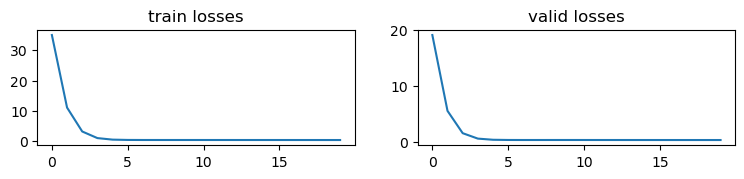

In [136]:
trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [137]:
# Once trained, you can use the model for prediction
from sklearn.metrics import mean_squared_error
def evaluateur(test_data, test_targets, target_year, time_test):
    model.eval()
    predictions = []
    targets_list = []
    dates_list = []
    tic()
    
    start_date = [dt for dt in datetime_objects if dt.year == target_year]
    indexes_year = [i for i, dt in enumerate(time_test) if dt in start_date] #extract the indexes of the year of interest
    test_dataset = TensorDataset(test_data[indexes_year], test_targets[indexes_year])
    test_loader = DataLoader(test_dataset, batch_size=batch_size)#, collate_fn=custom_collate)
    with th.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predicted_temperatures = model(inputs)
            predictions.append(predicted_temperatures.detach().cpu().numpy())
            targets_list.append(targets.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    targets_array = np.concatenate(targets_list)

    # Calculate mean squared error (MSE)
    print(predictions.shape[0])
    print(targets_array.shape)
    # Reshape the predicted tensor
    predicted_tensor = th.from_numpy(predictions)
    predicted_test = predicted_tensor.view(predicted_tensor.shape[0], -1)

# Reshape the target tensor
    target_tensor = th.from_numpy(targets_array)
    target_test = target_tensor.view(target_tensor.shape[0], -1)

    print(predicted_test.shape)
    print(target_test.shape)
    mse = mean_squared_error(target_test, predicted_test)

    # Print or use the MSE for further analysis
    print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")
    return(predictions, targets_array, mse, start_date)
        
    toc()


In [90]:
predictions, targets_array, mse, start_date = evaluateur(test_data, test_targets, 2013, time_test)

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 1.1265


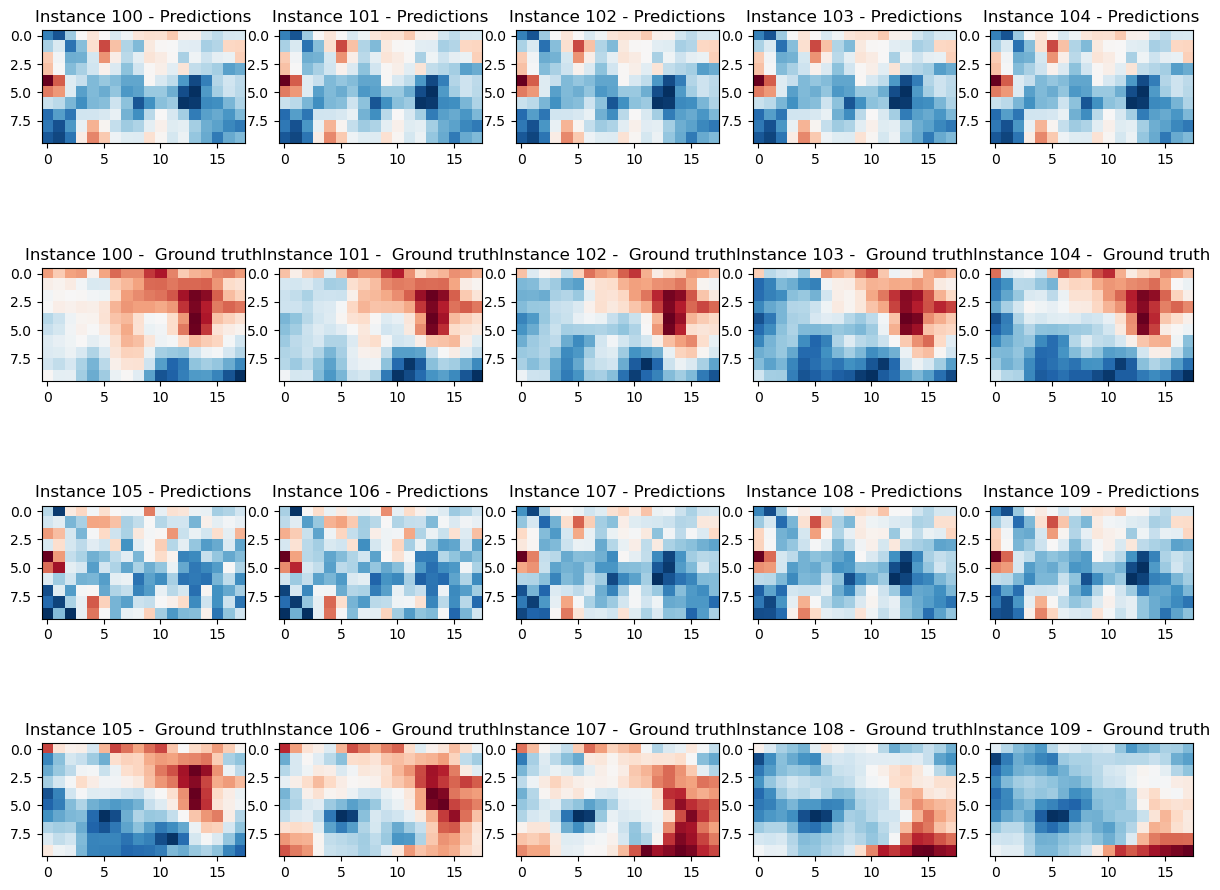

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your tensor is named 'tensor' with shape (365, 15, 15)

# Randomly choose 10 instances from the first dimension
indices = [i for i in range(100,110)]
indices=np.array(indices)

# Create a grid of subplots to display the maps
fig, axes = plt.subplots(4, 5, figsize=(12, 10))

# Iterate over the chosen instances
for i, index in enumerate(indices):
    # Get the instance from the tensor
    instance1 = predictions[index]
    instance2=targets_array[index]
    # Normalize the values of the instance between 0 and 1
    normalized_instance1 = (instance1 - np.min(instance1)) / (np.max(instance1) - np.min(instance1))
    normalized_instance2 = (instance2 - np.min(instance2)) / (np.max(instance2) - np.min(instance2))

    # Generate the map with colors varying from red to blue
    colors1 = plt.cm.RdBu(normalized_instance1)
    colors2 = plt.cm.RdBu(normalized_instance2)

    # Plot the map on the corresponding subplot
    ax1 = axes[2*(i // 5), i % 5]
    ax2 = axes[2*(i // 5) + 1, i % 5]
    ax1.imshow(colors1, cmap='RdBu')
    ax2.imshow(colors2, cmap='RdBu')
    ax1.set_title(f'Instance {index} - Predictions')
    ax2.set_title(f'Instance {index} -  Ground truth')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [66]:
amp=(maximums[8]-minimums[8]).numpy()
print(type(amp))

<class 'numpy.ndarray'>


365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0027


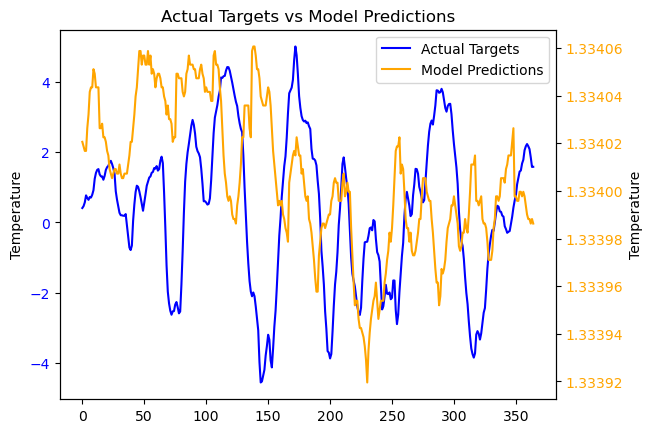

366
(366, 10, 18)
torch.Size([366, 180])
torch.Size([366, 180])
Mean Squared Error (MSE) on the test set: 0.0044


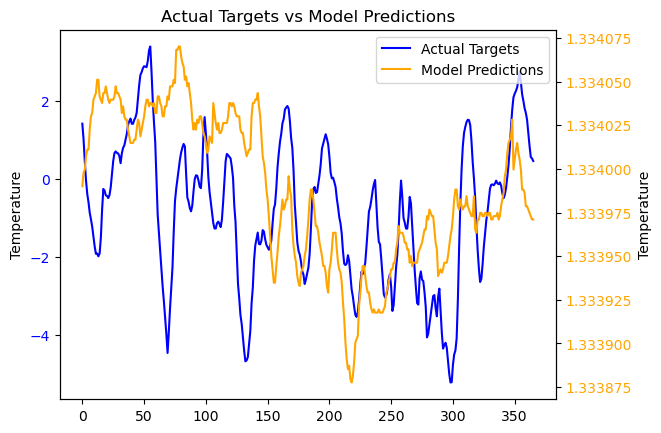

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0042


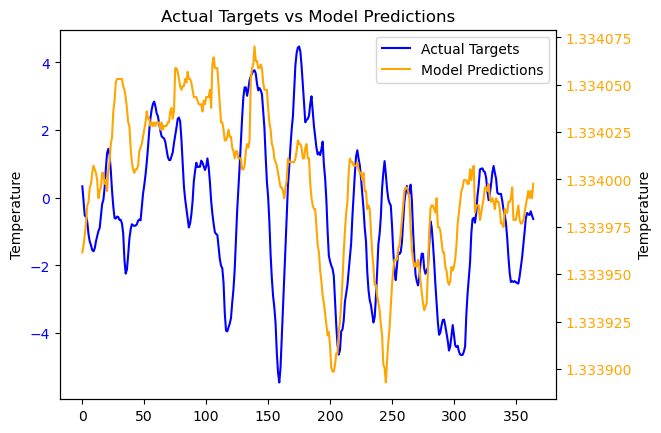

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0025


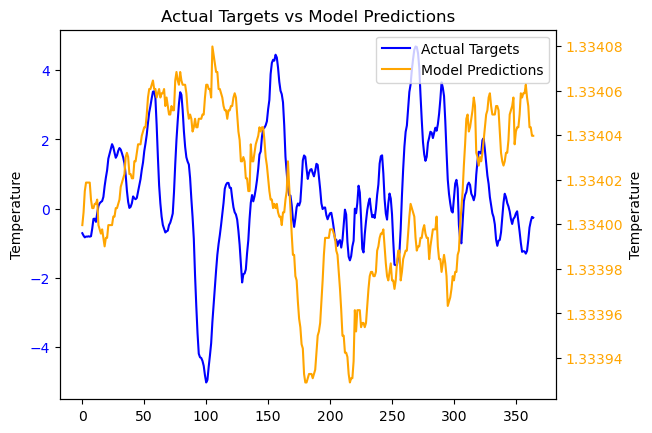

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0045


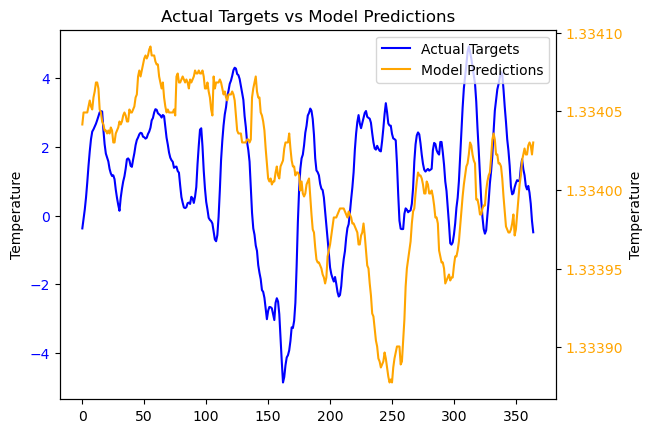

366
(366, 10, 18)
torch.Size([366, 180])
torch.Size([366, 180])
Mean Squared Error (MSE) on the test set: 0.0036


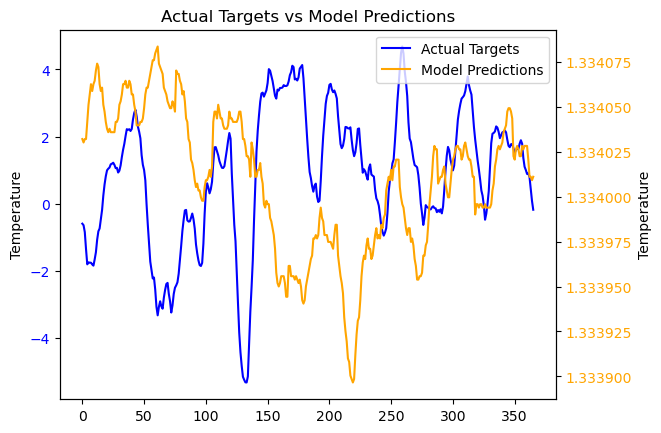

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0054


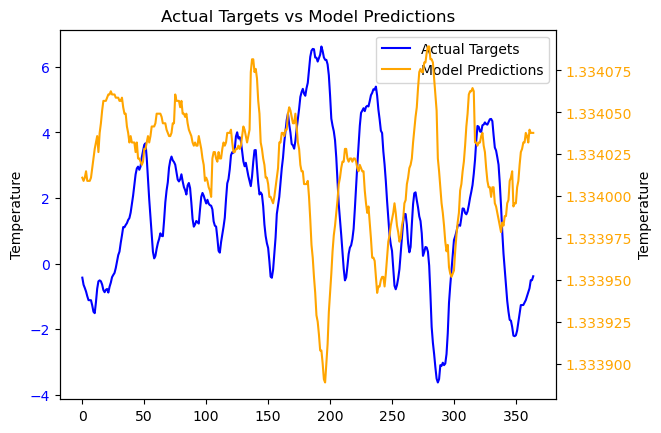

143
(143, 10, 18)
torch.Size([143, 180])
torch.Size([143, 180])
Mean Squared Error (MSE) on the test set: 0.0027


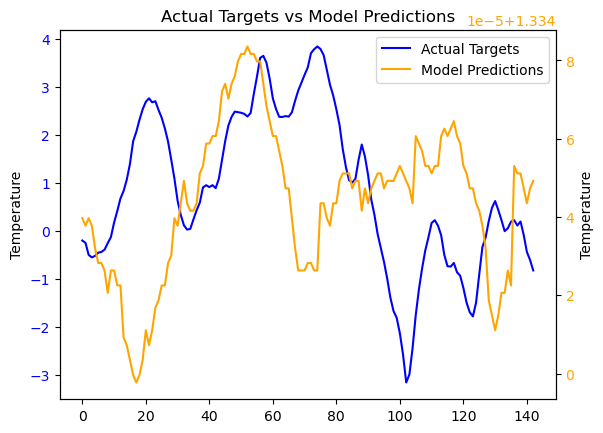

In [138]:
import matplotlib.pyplot as plt

for year in range(2011, 2019):
    predictions, targets_array, mse, start_date = evaluateur(test_data, test_targets, year, time_test)
    # Retrieves Normalization
    amp=(maximums[8]-minimums[8]).numpy()
    mini=minimums[8].numpy()
    predictions_real = predictions*(amp)+mini
    targets_real = targets_array*(amp)+mini

    fig, ax1 = plt.subplots()

    # Plot the actual targets on the first y-axis
    ax1.plot(targets_real[:, 3, 3], label='Actual Targets', color='blue')
    ax1.set_ylabel('Temperature')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the model predictions
    ax2 = ax1.twinx()
    ax2.plot(predictions_real[:, 3, 3], label='Model Predictions', color='orange')
    ax2.set_ylabel('Temperature')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set labels and title
    plt.xlabel('Time')
    plt.title('Actual Targets vs Model Predictions')

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    # Show the plot
    plt.show()


In [139]:

#Provide the skills for each year between 2011 and 2018

years=[2011+i for i in range(8)]
result3=pd.DataFrame()
result3['year']=years
skills=[]
for year in years:
    t = time.time()
    predictions, targets_array, mse, start_date = evaluateur(test_data, test_targets, year, time_test)
    start_date = pd.DataFrame(start_date)
    amp=(maximums[8]-minimums[8]).numpy()
    mini=minimums[8].numpy()
    predictions = predictions*(amp)+mini
    targets_array = targets_array*(amp)+mini
    targets_array = pd.DataFrame(targets_array.reshape(-1,1))
    predictions = pd.DataFrame(predictions.reshape(-1,1))
    results = pd.concat((start_date, targets_array, predictions),axis=1)
    results.columns = ['start_date', 'targets_array', 'predictions']

    #print(results)
    #results = pd.DataFrame(results)
    #print(results.shape)
    skill=get_col_skill(results,'targets_array','predictions',date_col='start_date')
    skills.append(skill)
    print('{}'.format(year)+' est bon')
    print('Temps pour {}={}'.format(year,time.time()-t))
result3['skill']=skills
print(result3)

365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0027
2011 est bon
Temps pour 2011=0.1942434310913086
366
(366, 10, 18)
torch.Size([366, 180])
torch.Size([366, 180])
Mean Squared Error (MSE) on the test set: 0.0044
2012 est bon
Temps pour 2012=0.18953657150268555
365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0042
2013 est bon
Temps pour 2013=0.2037503719329834
365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0025
2014 est bon
Temps pour 2014=0.20798420906066895
365
(365, 10, 18)
torch.Size([365, 180])
torch.Size([365, 180])
Mean Squared Error (MSE) on the test set: 0.0045
2015 est bon
Temps pour 2015=0.19259071350097656
366
(366, 10, 18)
torch.Size([366, 180])
torch.Size([366, 180])
Mean Squared Error (MSE) on the test set: 0.0036
2016 est bon
Temps pour 2016=0.21051335334777832
365
(365, 10, 18)
torch.Size([

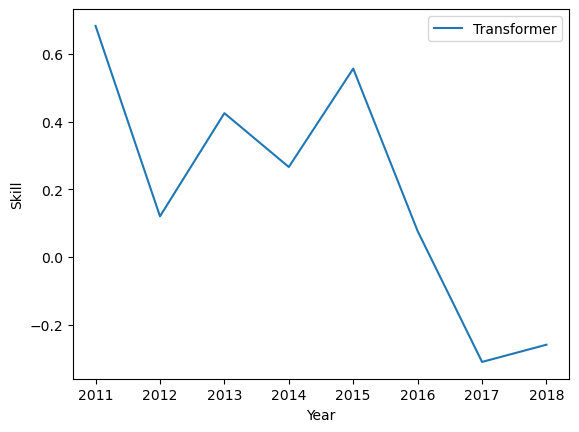

In [140]:
result3['skill']=result3['skill']
plt.plot(result3['year'],result3['skill'],label='Transformer')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Skill')

plt.show()

In [142]:
moyenne=result3.loc[0:7]
print(moyenne['skill'].mean())

0.19464475756816096


In [ ]:
predictions, targets_array, mse, start_date = evaluateur(test_data, test_targets, 2012, time_test)

## SHAP Values Calculation

In [13]:
import shap

model.eval()
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    explainer = shap.DeepExplainer(model, inputs)
    shap_values = explainer.shap_values(inputs)
    shap.summary_plot(shap_values, inputs,plot_type='bar')

OutOfMemoryError: CUDA out of memory. Tried to allocate 282.00 MiB (GPU 0; 14.76 GiB total capacity; 13.62 GiB already allocated; 155.88 MiB free; 13.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF